# Перевод текста с помощью модели seq2seq с механизмом внимания

Обучение модели seq2seq для перевода с испанского на английский на основе статьи [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5) (Luong et al., 2015).

<table>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN%2Battention-words-spa.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>Encoder/decoder c механизмом внимания</th>
<tr>
</table>

Несмотря на то, что архитектура sequence-to-sequence несколько устарела, это полезный проект для получения представление о моделях sequence-to-sequence и механизмах внимания.

## Установка необходимых модулей и библиотек

In [1]:
# pip install "einops==0.6.0"

In [2]:
# pip install "tensorflow-text==2.11"

In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

2024-12-02 14:28:06.017589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


При решении такого рода задач используется множество низкоуровневых API, в которых легко перепутать размерности. Этот класс используется для проверки размерностей на протяжении всего решения.


In [4]:
#@title
class ShapeChecker():
  def __init__(self):
    # Храним в кэше каждое увиденное название оси
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # Если имя оси новое, добавляем его длину в кэш.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## Исходные данные

Будем использовать набор языковых данных, предоставленный [Anki](http://www.manythings.org/anki/). Этот набор данных содержит пары языковых переводов в формате:

```
English + TAB + The Other Language + TAB + Attribution
```
Например,
```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

Они доступны на разных языках.

### Загрузка и подготовка данных

После загрузки набора данных вам необходимо выполнить следующие действия для подготовки данных:

1. Добавьте к каждому предложению маркеры *START* и *END*.
2. Очистите предложения, удалив специальные символы.
3. Создайте индекс слов и обратный индекс слов (сопоставление словарей из `word → id` и `id → word`).
4. Увеличьте каждое предложение до максимальной длины.

In [5]:
def load_data(path):
  with open(path, 'r', encoding='utf-8') as file:
    text = file.read()

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [6]:
target_raw, context_raw = load_data('/Users/nikitafedorov/Desktop/reu_ml/ML7/spa-eng/spa.txt')
print(context_raw[100])

¡Salga de aquí!


In [7]:
print(target_raw[100])

Go away!


### Создадим датасет с помощью `tf.data`

Самый простой способ создать набор данных — это создать его из Python `list`.

Из этих массивов строк можно создать перемешанные и сгруппированные строки с помощью `tf.data.Dataset` :


In [8]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

2024-12-02 14:29:16.249842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:3])
  print()
  print(example_target_strings[:3])
  break

tf.Tensor(
[b'\xc3\x89ste es el lugar donde naci\xc3\xb3 mi padre.'
 b'Todos miramos por la ventana.'
 b'Tom pareci\xc3\xb3 bastante sorprendido cuando oy\xc3\xb3 que Mary y John se hab\xc3\xadan casado.'], shape=(3,), dtype=string)

tf.Tensor(
[b'This is the place where my father was born.'
 b'All of us looked through the window.'
 b'Tom seemed quite surprised when he heard that Mary and John had gotten married.'], shape=(3,), dtype=string)


### Предварительная обработка текста

Создадим модель, которую можно экспортировать как `tf.saved_model`. Чтобы сделать эту экспортированную модель полезной, она должна принимать входные данные в виде строки `tf.string`  и возвращать данные в виде строки `tf.string`/

Вся обработка текста происходит внутри модели с использованием слоя `layers.TextVectorization`.


#### Стандартизация

Модель имеет дело с многоязычным текстом с ограниченным словарным запасом. Поэтому важно будет стандартизировать входной текст.

Первым шагом является нормализация `Unicode` для разделения диакритических символов и замены совместимых символов их эквивалентами `ASCII`.

Пакет `tensorflow_text` содержит операцию нормализации `Unicode`:
```python
text.normalize_utf8(
    input, normalization_form=&#x27;NFKC', name=None
)
```
`normalization_form` - одно из следующих строковых значений: 'NFC', 'NFKC', 'NFD', 'NFKD'. По умолчанию используется 'NFKC'. Подробнее про кодировки можно прочитать [здесь](https://www.unicode.org/reports/tr15/)

In [10]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
tf_text.normalize_utf8(example_text, 'NFKD').numpy()

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'


b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'

Нормализация `Unicode` станет первым шагом в функции стандартизации текста.

In [11]:
def tf_lower_and_split_punct(text):
  # Разделяем символы с ударением
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Оставляем пробелы от a до z и выберем пунктуацию
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Добавляем пробелы вокруг знаков препинания
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Удаляем пробелы
  text = tf.strings.strip(text)

  # Добавляем метки начала и конца текста
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Векторизация текста

Для векторизации текста будем использовать слой `tf.keras.layers.TextVectorization`, который будет выполнять извлечение словаря и преобразование входного текста в последовательности токенов.

In [13]:
# Задаем максимальный размер словаря
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

Слой `TextVectorization` и многие другие слои предварительной обработки `Keras` имеют метод `adapt`. Этот метод считывает одну эпоху обучающих данных и работает во многом как `Model.fit`. Этот метод `adapt` инициализирует слой на основе данных. Здесь он определяет словарь.


In [14]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Первые 10 слов из словаря
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

Это испанский `TextVectorization` слой, создадим аналогичным образом `.adapt()` английский.

In [15]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
# Первые 10 слов из словаря
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Теперь эти слои можно преобразовать batch строк в batch идентификаторов токенов.

In [16]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 40, 15, 7, 265, 76, 928, 24, 127, 4, 3],
 [2, 67, 1, 21, 11, 376, 4, 3],
 [2, 10, 1606, 331, 1156, 53, 1212, 5, 32, 33, 228, 17, 1621, 786, 4, 3]]>

Для преобразования идентификаторов токенов обратно в текст можно использовать метод `get_vocabulary`.

In [17]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] este es el lugar donde nacio mi padre . [END]'

Возвращаемые идентификаторы токенов дополняются нулями. Это можно легко превратить в маску.

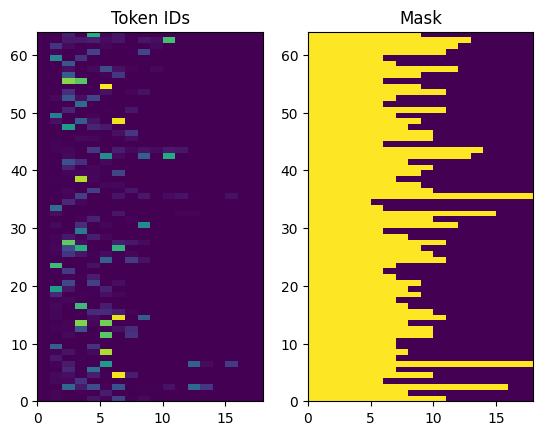

In [18]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')
plt.show()

### Обработка набора данных



Функция `process_text` преобразует строки `Datasets` в тензоры идентификаторов токенов с дополнением 0. Она также преобразует пары `(context, target)` в пары `((context, target_in), target_out)` для обучения с помощью `keras.Model.fit`. `Keras` ожидает пары `(inputs, labels)`, входными данными являются `(context, target_in)`, а метками - `target_out`. Разница между `target_in` и `target_out` заключается в том, что они сдвинуты на один шаг относительно друг друга, так что в каждом местоположении метка является следующим токеном.



In [19]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Вот первая последовательность каждого из них из первого batch.

In [20]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   2   26 3042    1    1    1  303  664   46  671]

[   2    5 2762 1063    1 3897  178    5  618    4]
[   5 2762 1063    1 3897  178    5  618    4    3]


## Encoder/decoder

На каждом временном шаге выход декодера объединяется с выходом кодера для прогнозирования следующего слова.

Оригинал [слева] содержит несколько дополнительных соединений, которые намеренно опущены из модели справа, т.к. они, как правило, не нужны и сложны в реализации. Эти недостающие соединения:

* передают состояние из RNN кодера в RNN декодера;
* подают выходной сигнал внимания обратно на вход RNN.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>Оригинал из статьи <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>Упрощенная модель</th>
<tr>
</table>


Определим константы для модели.

In [21]:
UNITS = 256

### Encoder

Цель кодировщика — обработать контекстную последовательность в последовательность векторов, которые полезны для декодера, поскольку он пытается предсказать следующий выход для каждого временного шага. Поскольку контекстная последовательность постоянна, нет ограничений на то, как информация может течь в кодировщике, поэтому используем двунаправленную RNN для выполнения обработки:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>Двунаправленная RNN</th>
<tr>
</table>

Encoder:

1. Получает список идентификаторов токенов (из `context_text_processor`).
2. Ищет вектор embedding для каждого токена (используя `layers.Embedding`).
3. Обрабатывает embeddings в новую последовательность (используем двунаправленный `layers.GRU`).
4. Возвращает обработанную последовательность. Это будет передано голове `attention`.

In [22]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # Слой embedding преобразует токены в векторы
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # Слой RNN обрабатывает эти векторы последовательно
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Возвращаем последовательность и состояние
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. Слой embedding просматривает вектор embedding для каждого токена
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. GRU обрабатывает последовательность embeddings
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Возвращаем новую последовательность embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Применим `Encoder`

In [23]:
# Кодируем входную последовательность
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 256)


### Слой внимания

Слой внимания позволяет декодеру получить доступ к информации, извлеченной кодером. Он вычисляет вектор из всей последовательности контекста и добавляет его к выходным данным декодера.

Самый простой способ рассчитать один вектор из всей последовательности — взять среднее значение по последовательности (`layers.GlobalAveragePooling1D`). Слой внимания аналогиче, но вычисляет **взвешенное** среднее значение по последовательности контекста. Где веса вычисляются на основе комбинации векторов контекста и "запроса".


<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>Слой внимания</th>
<tr>
</table>

In [24]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Сохраняем результаты оценки внимания для последующего построения графика.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [25]:
attention_layer = CrossAttention(UNITS)

# Обращаем внимание на закодированные токены
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Последовательность контекста, размерность (batch, s, units): {ex_context.shape}')
print(f'Последовательность targetов, размерность (batch, t, units): {ex_tar_embed.shape}')
print(f'Результат внимания, размерность (batch, t, units): {result.shape}')
print(f'Веса внимания, размерность (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Последовательность контекста, размерность (batch, s, units): (64, 20, 256)
Последовательность targetов, размерность (batch, t, units): (64, 18, 256)
Результат внимания, размерность (batch, t, units): (64, 18, 256)
Веса внимания, размерность (batch, t, s):    (64, 18, 20)


Значения весов внимания в сумме будут равны "1" по всей последовательности контекста в каждом месте последовательности target.


In [26]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.0000001 , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 0.9999999 , 1.        , 1.0000001 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ], dtype=float32)

Вот веса внимания в последовательности контекста при `t=0`:


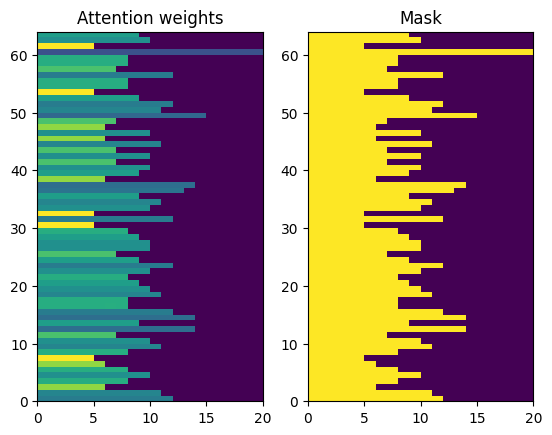

In [27]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Из-за малой случайности инициализации все значения коэффициента внимания изначально близки к `1/(sequence_length)`. Модель научится делать их менее однородными по мере прохождения обучения.

### Decoder

Задача декодера - генерировать прогнозы для следующего токена в каждом местоположении целевой последовательности.

1. Он просматривает ембеддиги для каждого токена в целевой последовательности.
2. Использует RNN для обработки целевой последовательности и отслеживания того, что он сгенерировал на данный момент.
3. Использует выходные данные RNN в качестве "запроса" к модели внимания при обработке выходных данных кодировщика.
4. В каждом месте вывода он предсказывает следующий токен.

При обучении модель предсказывает следующее слово в каждом местоположении. Поэтому важно, чтобы информация передавалась через модель только в одном направлении. Декодер использует однонаправленный (не двунаправленный) RNN для обработки целевой последовательности.

При выполнении логического вывода с помощью этой модели он выдает по одному слову за раз и они передаются обратно в модель.


<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>Однонаправленная RNN</th>
<tr>
</table>

Инициализируем класс `Decoder`, который создает все необходимые слои.

In [28]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. Слой embedding преобразует идентификаторы токенов в векторы
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. RNN отслеживает все, что было сгенерировано на данный момент
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. Результатом RNN будет запрос для слоя внимания.
    self.attention = CrossAttention(units)

    # 4. Этот полносвязный слой генерирует логиты для каждого выходного токена
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Обучение

Далее метод `call` принимает 3 аргумента:

* `inputs` - `context, x` - пара, где:
  * `context`- это контекст из выходных данных кодировщика.
  * `x` - это вход целевой последовательности.
* `state` - необязательный аргумент, предыдущее состояние `state` из декодера (внутреннее состояние RNN декодера). Передайте состояние из предыдущего запуска, чтобы продолжить генерацию текста с того места, на котором вы остановились.
* `return_state` - [По умолчанию: `False`] — Установите это значение `True`, чтобы вернуть состояние RNN.



In [29]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Находим embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

Создадим экземпляр декодера для проверки:

In [30]:
decoder = Decoder(target_text_processor, UNITS)

В процессе обучения будем использовать декодер следующим образом.
Учитывая контекст и целевые токены, для каждого целевого токена он предсказывает следующий целевой токен.

In [31]:
logits = decoder(ex_context, ex_tar_in)

print(f'Размерность выходного сигнала энкодера: (batch, s, units) {ex_context.shape}')
print(f'Размерность входных целевых токенов: (batch, t) {ex_tar_in.shape}')
print(f'Размерность логитов: (batch, t, target_vocabulary_size) {logits.shape}')

Размерность выходного сигнала энкодера: (batch, s, units) (64, 20, 256)
Размерность входных целевых токенов: (batch, t) (64, 18)
Размерность логитов: (batch, t, target_vocabulary_size) (64, 18, 5000)


#### Вывод

Чтобы использовать декодер для вывода, понадобятся еще несколько методов

In [32]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [33]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [34]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # Если последовательность выдает `end_token`, установите для нее значение `done`
  done = done|(next_token == self.end_token)
  # Как только последовательность выполнена, она производит только 0-padding
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

С помощью этих дополнительных функций напишем цикл генерации.

In [35]:
# Настроим переменные цикла
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Делаем один шаг
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Добавляем токен в выходные данные
  tokens.append(next_token)

# Объединяем все токены вместе
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Преобразуем токены обратно в строку
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'case helicopter much answer swimsuit whos tap poisonous memory angeles',
       b'careless studied belonged switzerland chairs imagined has professor shouldve jealous',
       b'deliver beware increased simple drunken inevitable groups terror debts move'],
      dtype=object)

Т.к. модель не обучена, она выводит элементы из словаря почти равномерно, случайным образом.

## Модель

Объединим все компоненты модели, чтобы построить модель для обучения.




In [36]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Строим кодер и декодер
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Удалим маску keras, чтобы keras не увеличивал loss+accuracy
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

Во время обучения модель будет использоваться следующим образом:

In [37]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Токены контекста, размерность: (batch, s, units) {ex_context_tok.shape}')
print(f'Токены таргетов, размерность: (batch, t) {ex_tar_in.shape}')
print(f'логиты, размерность: (batch, t, target_vocabulary_size) {logits.shape}')

Токены контекста, размерность: (batch, s, units) (64, 20)
Токены таргетов, размерность: (batch, t) (64, 18)
логиты, размерность: (batch, t, target_vocabulary_size) (64, 18, 5000)


### Обучение

Для обучения необходимо реализовать собственные функции маскированных потерь и точности

In [38]:
def masked_loss(y_true, y_pred):
    # Вычисляем потерю для каждой сущности в батче
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Возвращаем итог
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [39]:
def masked_acc(y_true, y_pred):
    # Вычисляем потери для каждой сущности в батче
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Настроим модель для обучения.

In [40]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

Модель инициализируется случайным образом и должна давать примерно равномерные выходные вероятности. Поэтому легко предсказать, какими должны быть начальные значения метрик.

In [41]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

Это должно примерно соответствовать значениям, возвращаемым в результате выполнения нескольких шагов оценки.

In [42]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 15s 148ms/step - loss: 8.5157 - masked_acc: 2.7950e-04 - masked_loss: 8.5157


{'loss': 8.51566219329834,
 'masked_acc': 0.00027950332150794566,
 'masked_loss': 8.51566219329834}

In [43]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 53s 326ms/step - loss: 5.0272 - masked_acc: 0.2646 - masked_loss: 5.0272 - val_loss: 4.0753 - val_masked_acc: 0.3592 - val_masked_loss: 4.0753
Epoch 2/100
100/100 [==============================] - 33s 327ms/step - loss: 3.7223 - masked_acc: 0.3987 - masked_loss: 3.7223 - val_loss: 3.3617 - val_masked_acc: 0.4446 - val_masked_loss: 3.3617
Epoch 3/100
100/100 [==============================] - 32s 325ms/step - loss: 3.1021 - masked_acc: 0.4823 - masked_loss: 3.1021 - val_loss: 2.8929 - val_masked_acc: 0.5101 - val_masked_loss: 2.8929
Epoch 4/100
100/100 [==============================] - 33s 326ms/step - loss: 2.6914 - masked_acc: 0.5397 - masked_loss: 2.6914 - val_loss: 2.4997 - val_masked_acc: 0.5628 - val_masked_loss: 2.4997
Epoch 5/100
100/100 [==============================] - 34s 338ms/step - loss: 2.4416 - masked_acc: 0.5770 - masked_loss: 2.4416 - val_loss: 2.2702 - val_masked_acc: 0.6003 - val_masked_loss: 2.2702
Epoch 6/10

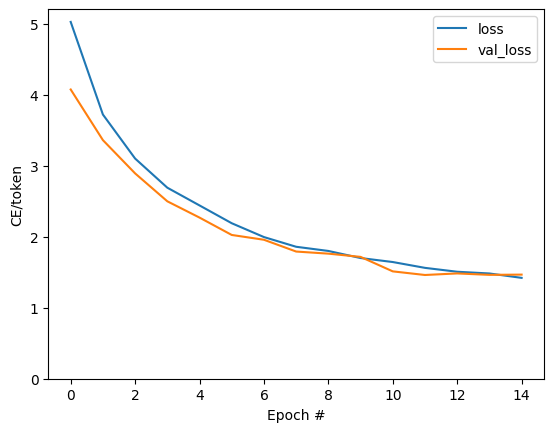

In [44]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

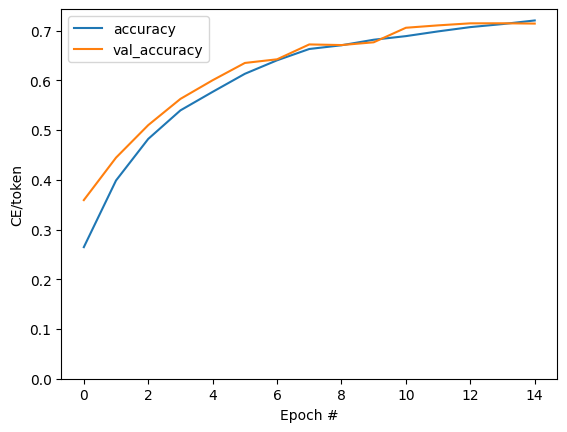

In [45]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Перевод

Теперь, когда модель обучена, реализуем функцию для выполнения полного `text => text` перевода. Этот код в основном идентичен примеру [вывода](#Вывод) в разделе [декодера](#Decoder), но он также захватывает веса внимания.


In [46]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Обрабатываем вводимый текст
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Настройка входов
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Генерируем следующий токен
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Собираем сгенерированные токены
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Составляем списки токенов и весов внимания.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Вот два вспомогательных метода, использованных выше, для преобразования токенов в текст и получения следующего токена.

In [47]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home?
result[0].numpy().decode()

'is still still at home ? '

Используем этот результат для создания графика внимания.



In [48]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 10}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.show()

/var/folders/ln/gf48qg5j3w72sqr7lf9y2slh0000gn/T/ipykernel_7607/1024214768.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/ln/gf48qg5j3w72sqr7lf9y2slh0000gn/T/ipykernel_7607/1024214768.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


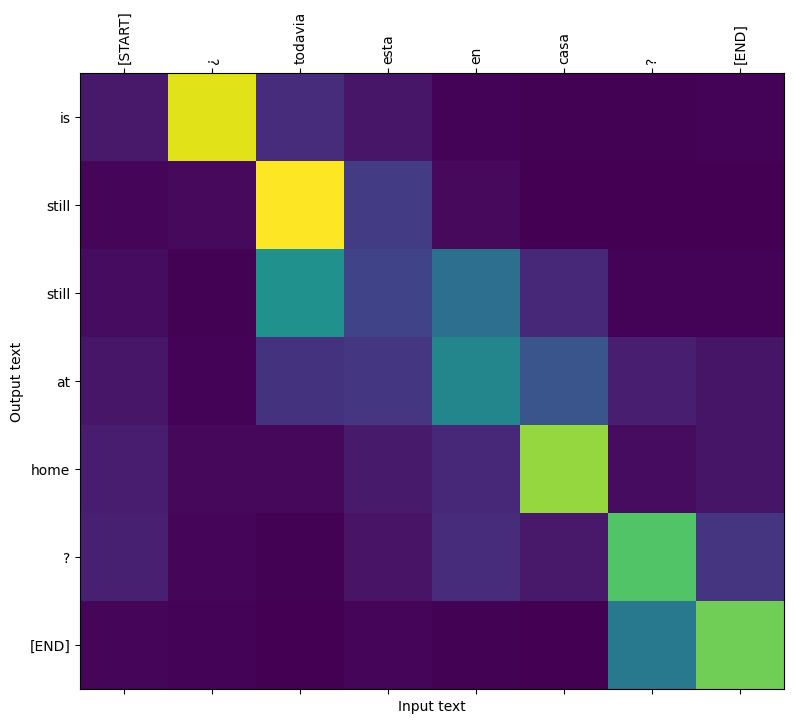

In [49]:
model.plot_attention('¿Todavía está en casa?') # Are you still home?

Переведем еще несколько предложений

/var/folders/ln/gf48qg5j3w72sqr7lf9y2slh0000gn/T/ipykernel_7607/1024214768.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/ln/gf48qg5j3w72sqr7lf9y2slh0000gn/T/ipykernel_7607/1024214768.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


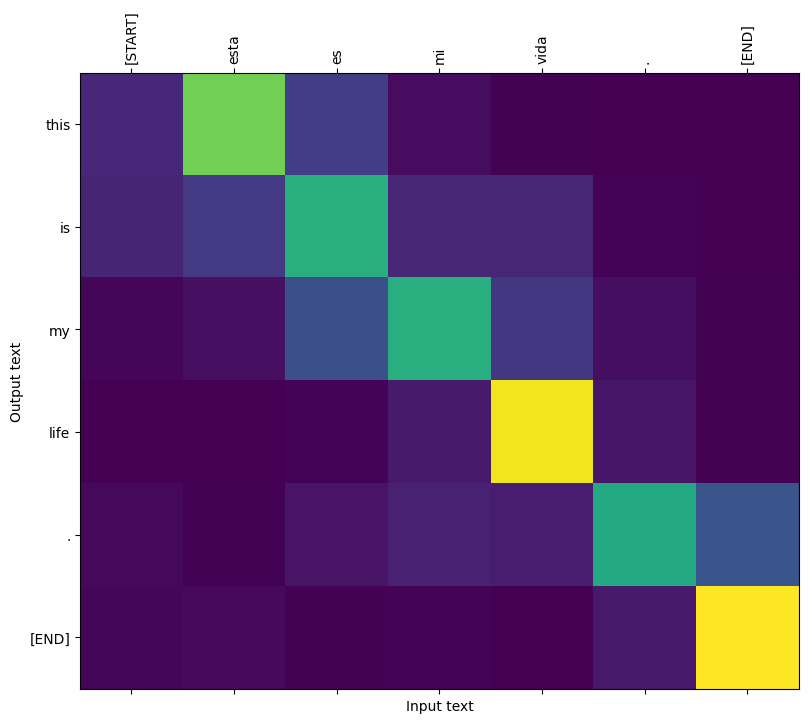

CPU times: user 751 ms, sys: 127 ms, total: 877 ms
Wall time: 531 ms


In [50]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

/var/folders/ln/gf48qg5j3w72sqr7lf9y2slh0000gn/T/ipykernel_7607/1024214768.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/ln/gf48qg5j3w72sqr7lf9y2slh0000gn/T/ipykernel_7607/1024214768.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


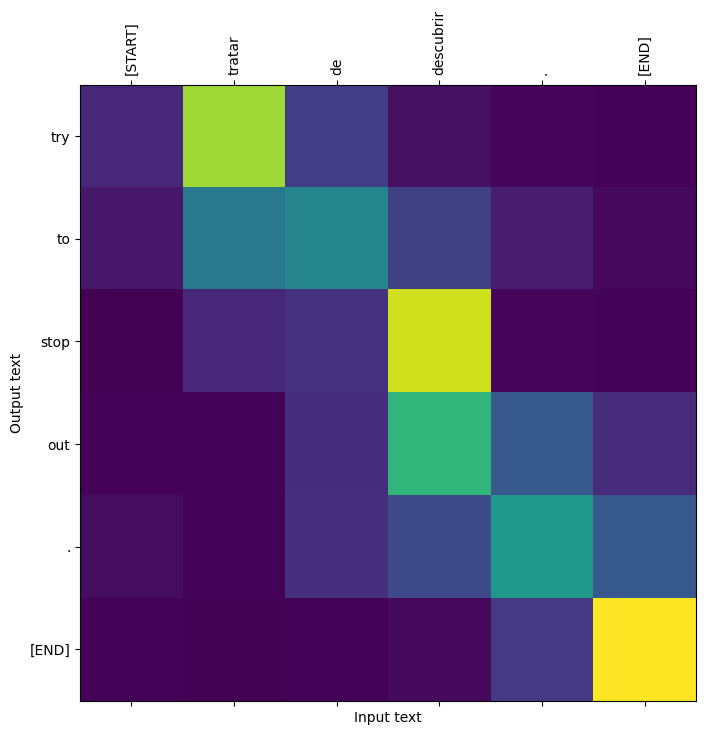

CPU times: user 703 ms, sys: 115 ms, total: 818 ms
Wall time: 494 ms


In [51]:
%%time
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')

Короткие предложения часто работают хорошо, но если входные данные слишком длинные, модель буквально теряет фокус и перестает давать разумные прогнозы. Для этого есть две основные причины:

1. Модель была обучена с помощью принудительной подачи учителем правильного токена на каждом шаге, независимо от предсказаний модели. Модель могла бы стать более надежной, если бы ей иногда давали ее собственные предсказания.
2. Модель имеет доступ к своему предыдущему выходу только через состояние RNN. Если состояние RNN теряет отслеживание того, где оно было в последовательности контекста, то у модели нет возможности восстановиться. Трансформеры улучшают это, позволяя декодеру смотреть на то, что он вывел до сих пор.

Исходные данные отсортированы по длине, поэтому попробуем перевести самую длинную последовательность.

In [52]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/var/folders/ln/gf48qg5j3w72sqr7lf9y2slh0000gn/T/ipykernel_7607/1024214768.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/ln/gf48qg5j3w72sqr7lf9y2slh0000gn/T/ipykernel_7607/1024214768.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


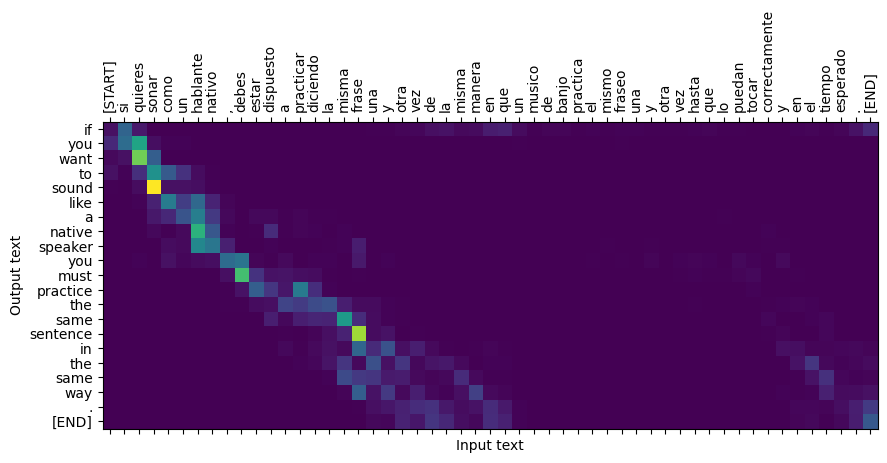

In [53]:
model.plot_attention(long_text)

Функция `translate` работает с батчами, поэтому если нужно перевести несколько текстов, лучше передать их все сразу, чем переводить по одному.

In [54]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [55]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

its very cold here . 
this is my life . 
his room is a disaster . 

CPU times: user 706 ms, sys: 11.1 ms, total: 717 ms
Wall time: 819 ms


In [56]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 313 ms, sys: 12.2 ms, total: 326 ms
Wall time: 554 ms


Таким образом, в целом эта функция генерации текста в основном выполняет свою работу, но здесь, в python, вы использовали ее только для быстрого выполнения. Попробуем экспортировать ее для использования в следующий раз.



### Export

Если вы хотите экспортировать эту модель, нужно будет обернуть метод `translate` в `tf.function`. Следующая реализация позволит выполнить это действие.


In [57]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [58]:
export = Export(model)

Запустим `tf.function` один раз, чтобы скомпилировать.

In [59]:
%%time
_ = export.translate(tf.constant(inputs))

2024-12-02 14:40:25.925237: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2900 num_cores: 8 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2024-12-02 14:40:25.926980: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2900 num_cores: 8 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SS

CPU times: user 2min, sys: 2.4 s, total: 2min 3s
Wall time: 2min 12s


In [60]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a disaster .                                            

CPU times: user 214 ms, sys: 45.4 ms, total: 259 ms
Wall time: 77.4 ms


Теперь функцию можно экспортировать с помощью `saved_model.save`.

In [61]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


CPU times: user 4min 39s, sys: 5.71 s, total: 4min 45s
Wall time: 4min 53s


In [62]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2024-12-02 14:46:14.469254: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-12-02 14:46:14.697684: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-12-02 14:46:18.244774: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-12-02 14:46:23.110241: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-12-02 14:46:25.508641: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _ou

CPU times: user 3min 11s, sys: 2.86 s, total: 3min 14s
Wall time: 3min 14s


In [63]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a disaster .                                            

CPU times: user 223 ms, sys: 47.1 ms, total: 270 ms
Wall time: 80.7 ms


#### [Необязательно] Используем динамический цикл

Стоит отметить, что эта первоначальная реализация не является оптимальной. В ней используется цикл python:

```
for _ in range(max_length):
  ...
  if tf.executing_eagerly() and tf.reduce_all(done):
    break
```

Цикл python относительно прост, но когда `tf.function` преобразует его в график, он **статически разворачивает** этот цикл. У развертывания цикла есть два недостатка:

1. Он создает копии тела цикла `max_length`. Таким образом, построение, сохранение и загрузка сгенерированных графиков занимает больше времени.
2. Необходимо выбрать фиксированное значение для параметра `max_length`.
3. Нельзя `прервать` статически развернутый цикл. Функция `tf.function`
  будет выполнять полные итерации `max_length` при каждом вызове.
  Вот почему `break` работает только при быстром выполнении. Это
  все еще немного быстрее, чем при активном выполнении, но не так быстро, как могло бы быть.

Чтобы устранить эти недостатки, приведенный ниже метод `translate_dynamic` использует цикл `tensorflow`:

```
for t in tf.range(max_length):
  ...
  if tf.reduce_all(done):
      break
```

Это похоже на цикл python, но когда вы используете тензор в качестве входных данных для цикла "for" (или условия цикла "while"), "tf.function" преобразует его в динамический цикл, используя такие операции, как "tf.while_loop`.

Здесь нет необходимости в `max_length`, это просто на случай, если модель застрянет, генерируя цикл типа: "Соединенные Штаты Соединенных штатов Соединенных Штатов Соединенных Штатов...`.

С другой стороны, чтобы накапливать токены из этого динамического цикла, вы не можете просто добавить их в "список" python, вам нужно использовать `tf.TensorArray`:
```
tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
...
for t in tf.range(max_length):
    ...
    tokens = tokens.write(t, next_token) # next_token shape is (batch, 1)
  ...
  tokens = tokens.stack()
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
```

Эта версия кода может быть значительно более эффективной:

In [64]:
#@title
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # Инициализируем аккумулятор
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Генерируем новый токен
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch t1')

    # Собираем сгенерированные токены
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Преобразуйте список сгенерированных идентификаторов токенов в список строк
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

При активном выполнении эта реализация работает наравне с оригиналом.

In [65]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 290 ms, sys: 11.7 ms, total: 302 ms
Wall time: 282 ms


Но если вы завернете его `tf.function`, то заметите два отличия.

In [66]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [67]:
export = Export(model)

Во-первых, трассировка выполняется гораздо быстрее, поскольку создается только одна копия тела цикла.

In [68]:
%%time
_ = export.translate(inputs)

2024-12-02 14:48:54.954963: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2900 num_cores: 8 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 6.86 s, sys: 72.7 ms, total: 6.93 s
Wall time: 6.81 s


`tf.function` намного быстрее, чем запуск с активным выполнением, а на небольших входных данных это часто в несколько раз быстрее, чем развернутая версия, поскольку она может выйти из цикла.

In [69]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 54.7 ms, sys: 12.5 ms, total: 67.2 ms
Wall time: 48 ms


Так что сохраним и эту версию.

In [70]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: dynamic_translator/assets


INFO:tensorflow:Assets written to: dynamic_translator/assets


CPU times: user 1min 45s, sys: 2.12 s, total: 1min 47s
Wall time: 1min 49s


In [71]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2024-12-02 14:51:06.390554: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2024-12-02 14:51:08.710664: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2024-12-02 14:51:09.792051: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2024-12-02 14:51:09.842370: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2024-12-02 14:51:11.634073: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _ou

CPU times: user 1min 8s, sys: 1.87 s, total: 1min 10s
Wall time: 1min 20s


In [72]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 52.5 ms, sys: 12.4 ms, total: 65 ms
Wall time: 25.6 ms


## Задание для самостоятельного выполнения

1. [Загрузите другой набор данных](http://www.manythings.org/anki/), чтобы поэкспериментировать с переводами, например, с английского на русский, с английского на немецкий или с английского на французский.
2. Поэкспериментируйте с обучением на большем наборе данных или с использованием большего количества эпох или при других паарметрах обучения модели.
3. Изучите пособие [`tensorflow_addons.seq2seq`](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt), в котором демонстрируются функциональные возможности более высокого уровня для реализации такого рода модели последовательностей, такие как `seq2seq.BeamSearchDecoder`. Попробуйте реализовать эту модель и сравнить результаты с построенной моделью `seq2seq`.
